In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline
import itertools
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import LabelEncoder



# 시계열

import statsmodels.api as sm



data_dir='C:/Download/2020bigcontest-master/2020bigcontest-master/data/total'
data_list = os.listdir(data_dir)


#항목별 저장
data_list_single_hitter = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('개인타자')]
data_single_hitter = [pd.read_csv(os.path.join(data_dir, data_list_single_hitter[x]), encoding='cp949') for x in range(len(data_list_single_hitter))]
data_list_single_pitcher = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('개인투수')]
data_single_pitcher = [pd.read_csv(os.path.join(data_dir, data_list_single_pitcher[x]), encoding='cp949') for x in range(len(data_list_single_pitcher))]
data_list_games = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('경기')]
data_games = [pd.read_csv(os.path.join(data_dir, data_list_games[x]), encoding='cp949') for x in range(len(data_list_games))]
data_list_player_enroll = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('등록선수')]
data_player_enroll = [pd.read_csv(os.path.join(data_dir, data_list_player_enroll[x]), encoding='cp949') for x in range(len(data_list_player_enroll))]
data_list_players = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('선수')]
data_players = [pd.read_csv(os.path.join(data_dir, data_list_players[x]), encoding='cp949') for x in range(len(data_list_players))]
data_list_teams = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀')]
data_teams = [pd.read_csv(os.path.join(data_dir, data_list_teams[x]), encoding='cp949') for x in range(len(data_list_teams))]
data_list_team_hitter = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀타자')]
data_team_hitter = [pd.read_csv(os.path.join(data_dir, data_list_team_hitter[x]), encoding='cp949') for x in range(len(data_list_team_hitter))]
data_list_team_pitcher = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀투수')]
data_team_pitcher = [pd.read_csv(os.path.join(data_dir, data_list_team_pitcher[x]), encoding='cp949') for x in range(len(data_list_team_pitcher))]


team_hitter=pd.concat(data_team_hitter,axis=0)
team_pitcher=pd.concat(data_team_pitcher,axis=0)
for i in range(0,5):
     data_team_hitter[i]['AVG']=data_team_hitter[i]['HIT']/data_team_hitter[i]['AB']


from datetime import datetime 
from datetime import datetime as dt
from dateutil.parser import parse
team_2016=data_team_hitter[0]
team_2017=data_team_hitter[1]
team_2018=data_team_hitter[2]
team_2019=data_team_hitter[3]
team_2020=data_team_hitter[4]
df_list=[team_2016,team_2017,team_2018,team_2019,team_2020]


In [2]:
def add_y_next(df):
    df['ym']=df['GDAY_DS'].apply(lambda x: str(x.year)+str(x.month))



    a=df['GDAY_DS'].apply(lambda x: str(x.year)+str(x.month)).unique()
    b=list(range(len(a)))
    list_C = [ x for x in zip(a,b) ]
    dict1=dict(list_C)
    


    df['dummy']=df['ym'].map(dict1)

    df['dummy+1']=df['dummy']+1

    y_dict=df.groupby(['dummy'])['AVG'].mean().to_dict()
    

    df['y_next']=df['dummy+1'].map(y_dict)

    df.drop(['dummy','dummy+1','ym','GDAY_DS'],axis=1,inplace=True)
    #걍 날짜는 삭제(시계열 피쳐로 잡아주니까)
    df.dropna(inplace=True)#일단 드랍하고 진행
    return df

In [3]:
def team_hitter_eda(year, team_name):
    year_index = year - 2016 
    
    # team_hitter data에 해당 경기의 해당 팀의 홈 어웨이 여부 column 추가
    data_games_year = data_games[year_index]
    data_games_year = data_games_year[['G_ID', 'VISIT_KEY', 'HOME_KEY']]
    data_games_year = data_games_year.set_index('G_ID')
    
    data_team_hitter_year = data_team_hitter[year_index]
    data_team_hitter_year = pd.merge(data_team_hitter_year, data_games_year, how='left', on=['G_ID'])

    data_team_hitter_year_team = data_team_hitter_year[data_team_hitter_year.T_ID == team_name]
    df = data_team_hitter_year_team
    df['HOME_KEY'] = df['HOME_KEY'].map(lambda x: 1 if x == team_name else 0 )
    df = df.drop(columns = ['VISIT_KEY', 'G_ID'])
    
    df.reset_index(inplace=True, drop=True) #index 재정렬
    
    # LabelEncoding
    encoder = LabelEncoder()

    df['VS_T_ID'] = encoder.fit_transform(df['VS_T_ID']) #상대편
    df['TB_SC'] = encoder.fit_transform(df['TB_SC']) #이닝 초/말
    
    
    ### 이부분은 모든 EDA에서 동일하게 작성
    
    # GDAY_DS => Datetime type
    df['GDAY_DS'] = df['GDAY_DS'].astype(str) + (df['HEADER_NO']+1).astype(str)
    df['year']=df['GDAY_DS'].str.slice(0,4).astype(int)
    df['month']=df['GDAY_DS'].str.slice(4,6).astype(int)
    df['H1']=df['HIT']-df['H2']-df['H3']-df['HR']
    dt = []
    for i in df['GDAY_DS']:
        dt_ = datetime.strptime(i, '%Y%m%d%H')
        dt.append(dt_)
    df['GDAY_DS'] = pd.Series(dt)
    df['month']=df['GDAY_DS'].apply(lambda x: x.month)
    
    #장타율
    df['SLG']=(df['HIT']+df['HP']+df['BB'])/(df['AB']+df['BB']+df['HP']+df['SF'])
    #출루율
    df['OBA']=(df['H1']+2*df['H2']+3*df['H3']+4*df['HR'])/df['AB']
    df['W_OPS']=0.57* df['SLG']+0.43*df['OBA']
    
    
    
    df = df.drop(columns=['T_ID'])
    #lags
    #lags=[1,4,6,12,30,60]
    #for lag in lags:
    #    df['AVG_lag_'+str(lag)]=df['AVG'].shift(lag).astype(np.float16)
    #SK Expanding window 추가
    #df['expanding_AVG_mean']=df['AVG'].transform(lambda x: x.expanding(2).mean().astype(np.float16))
    #rolling window
    #df['rolling_AVG_mean']=df['AVG'].transform(lambda x: x.rolling(window=7).mean().astype(np.float16))
    #trend
    
    # 경기당 타율 column 생성
    df['AVG'] = df['HIT'] / df['AB']
    
    df['avg_AVG'] = df['AVG'].mean()
    df['AVG_trend'] = (df['AVG'] - df['avg_AVG']).astype(np.float16)
    df.drop(['avg_AVG'],axis=1,inplace=True)
    
    # Drop Categorical feature for 시계열 => coint 과정에서 singular matrix 발생
    df = df.drop(columns=[ 'HOME_KEY'])
    

#     df = df.drop(columns=['T_ID', 'HEADER_NO', 'CG_CK', 'BK'])
#     df = df.drop(columns=['TB_SC', 'HR', 'SB', 'VS_T_ID', 'HOME_KEY', 'HOLD', 'INN2', 'BF', 'CS', 'SH', 'HP', 'GD', 'ERR' ,'ER'])
    df_year_team_name = df
    
    return df_year_team_name

# 시계열 모델 사용 조건: 정상성 만족
- 이에 따라 팀 투수, 팀 타자 데이터에 대해 adfuller 정상성 검정 시행



In [4]:
from statsmodels.tsa.stattools import adfuller

def print_adfuller(inputSeries):
    result = adfuller(inputSeries)
    
    return result[1]

In [5]:
t=list(team_hitter['T_ID'].unique())
hit_team_list=[0]*10
for i in range(len(hit_team_list)):
    hit_team_list[i]=team_hitter[team_hitter['T_ID']==t[i]]

In [6]:
t=list(team_pitcher['T_ID'].unique())
pit_team_list=[0]*10
for i in range(len(pit_team_list)):

    pit_team_list[i]=team_pitcher[team_pitcher['T_ID']==t[i]]

## 팀 타자 데이터 정상성 검정

In [7]:

hit_con_cols=team_hitter.columns[6:]

results=[]
for t in hit_team_list:

    for i in hit_con_cols:
        
        
        pvalue=print_adfuller(t[i])
        if pvalue>0.05:
            print(i)
        results.append(pvalue)

KK


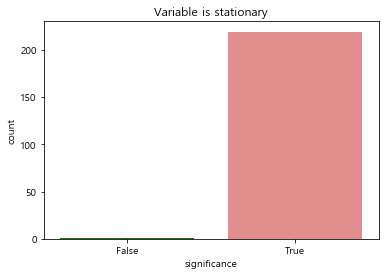

In [8]:

df=pd.DataFrame()
df['p-value']=results
df['significance']=df['p-value']<0.05
plt.title('Variable is stationary')
ax=sns.countplot(df['significance'],palette=['green','lightcoral'])

In [9]:
# 0.05에서 크게 벗어나지 않는 수준
df[df['significance']==False]['p-value']

147    0.05187
Name: p-value, dtype: float64

## 팀 투수 데이터 정상성 검정

In [10]:
pit_con_cols=team_pitcher.columns[8:]



results=[]
for t in pit_team_list:

    for i in pit_con_cols:
        
        
        pvalue=print_adfuller(t[i])
        if pvalue>0.05:
            print(i)
        results.append(pvalue)

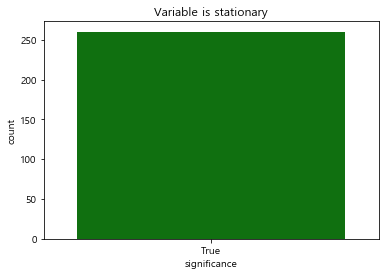

In [11]:
#투수데이터 정상성 검정
df=pd.DataFrame()
df['p-value']=results
df['significance']=df['p-value']<0.05
plt.title('Variable is stationary')
ax=sns.countplot(df['significance'],palette=['green','lightcoral'])

# 정규성 검정

In [12]:
#데이터 전체 취합하기
names=team_2016['T_ID'].unique()
df_list=[0]*5
df_list2=[0]*10
for i in range(len(df_list2)):
    for name in names:
        df_list[0]=team_hitter_eda(2016, name)
        df_list[1]=team_hitter_eda(2017, name)
        df_list[2]=team_hitter_eda(2018, name)
        df_list[3]=team_hitter_eda(2019, name)
        df_list[4]=team_hitter_eda(2020, name)
        df_list2[i]=add_y_next(pd.concat([df_list[0],df_list[1],df_list[2],df_list[3],df_list[4]],axis=0))



data=pd.concat([df_list2[0],df_list2[1],df_list2[2],df_list2[3],df_list2[4]
               ,df_list2[5],df_list2[6],df_list2[7],df_list2[8],df_list2[9]],axis=0)

In [13]:
#LG데이터만 대상으로 실행
LG=df_list2[0]
LG=LG.drop(['VS_T_ID','HEADER_NO'],axis=1)

In [14]:
LG

,TB_SC,PA,AB,RBI,RUN,HIT,H2,H3,HR,SB,...,P_HIT_CN,AVG,year,month,H1,SLG,OBA,W_OPS,AVG_trend,y_next
0,1,37,31,4,5,8,0,0,2,2,...,1,0.258065,2016,4,6,0.333333,0.451613,0.384194,-0.034760,0.322273
1,1,42,38,6,6,12,6,0,1,1,...,3,0.315789,2016,4,5,0.380952,0.552632,0.454774,0.022949,0.322273
2,0,39,28,5,6,6,1,1,0,2,...,2,0.214286,2016,4,4,0.435897,0.321429,0.386676,-0.078552,0.322273
3,0,32,30,2,2,5,0,0,1,0,...,1,0.166667,2016,4,4,0.218750,0.266667,0.239354,-0.126221,0.322273
4,0,40,36,2,2,10,1,0,0,0,...,1,0.277778,2016,4,9,0.350000,0.305556,0.330889,-0.015060,0.322273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,1,33,31,0,0,4,0,0,0,0,...,0,0.129032,2020,6,4,0.181818,0.129032,0.159120,-0.165894,0.324305
44,0,37,32,2,3,7,2,0,0,0,...,2,0.218750,2020,6,5,0.324324,0.281250,0.305802,-0.076233,0.324305
45,0,40,33,11,12,13,1,0,2,0,...,6,0.393939,2020,6,10,0.450000,0.606061,0.517106,0.098938,0.324305
46,0,35,33,0,0,5,0,0,0,0,...,0,0.151515,2020,6,5,0.200000,0.151515,0.179152,-0.143433,0.324305


In [15]:
from scipy.stats import shapiro

shapiro(LG['y_next'])
#LG만 해도p값이 0.05보다 작다. 즉, 유의수준 0.05하에서 타깃 값이 정규성을 만족한다는 귀무가설을 기각하게 된다

(0.9282090067863464, 1.0536190553081529e-16)

optimal lambda: 1.4029907791756053


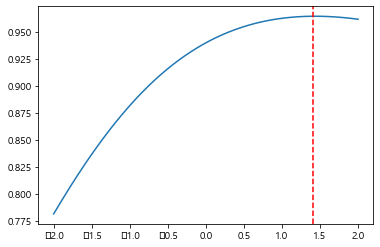

In [16]:
import scipy as sp

x, y = sp.stats.boxcox_normplot(LG['y_next'], -2, 2)
plt.plot(x, y);
y2, l = sp.stats.boxcox(LG['y_next'])
plt.axvline(x=l, color='r', ls="--");
print("optimal lambda:", l)

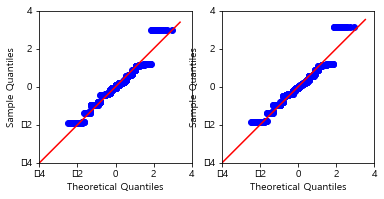

In [17]:

import statsmodels.graphics.gofplots as sm
ax1 = plt.subplot(121);
sm.qqplot(LG['y_next'], fit=True, line='45', ax=ax1);
ax1.axis("square"); ax1.set_xlim(-4, 4); ax1.set_ylim(-4, 4); 
ax2 = plt.subplot(122);
sm.qqplot(y2, fit=True, line='45', ax=ax2);
ax2.axis("square"); ax2.set_xlim(-4, 4); ax2.set_ylim(-4, 4);

In [18]:
from scipy.stats import shapiro

shapiro(y2)
#optimal lambda에서 box-cox변환 취해도, shapiro wilk test 결과 정규성을 만족하지 않는다.

(0.9315124154090881, 2.7151434659955704e-16)

- optimal lambda 를 사용하여 box-cox변환을 취해도 정규성을 만족시킬 방법이 없음
- 노이즈를 추가하면 정규성을 만족시킬 수 있으나 적절하지 못한 방법임.
- 따라서 논문에서 읽었던 best subset selection이나 ridge, lasso등의 회귀 기반의 모델은 사용이 어려워짐
- 이에 따라 분포에 대한 가정이 필요 없는 non-parametric한 방법의 사용이 필요하게 됨

# OUTLIER DETECTION


 ## 1. COLD GAME

In [19]:

#2017년 7월 2일 kt와 넥센의 경기 역시 강우콜드 처리되어 넥센이 승리를 가져갔다.
#이날 삼성 - SK 경기에선 5회 말 5대 6 리드 상황에서 우천 취소되어 SK가 이겼으며, 
#잠실에서 벌어진 KIA - LG의 경기 역시 강우콜드 선언이 되었다. 
team_2017[ (team_2017['GDAY_DS']==20170702)]
#즉,20170702WOKT0,20170702SSSK0,20170702HTLG0는 이상치로 간주하고 제거하는게 좋을 것 같다.

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,PA,AB,RBI,RUN,...,IB,HP,KK,GD,ERR,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN,AVG
766,20170702HTLG0,20170702,LG,HT,0,B,26,22,4,4,...,0,0,4,1,1,4,0.400000,10,4,0.363636
767,20170702HTLG0,20170702,HT,LG,0,T,41,34,12,13,...,1,2,7,0,0,8,0.333333,15,5,0.411765
768,20170702NCLT0,20170702,LT,NC,0,B,37,32,2,2,...,0,1,6,0,0,11,0.000000,7,0,0.250000
769,20170702NCLT0,20170702,NC,LT,0,T,36,30,1,1,...,0,1,8,1,2,8,0.000000,4,0,0.166667
770,20170702SSSK0,20170702,SK,SS,0,B,25,25,6,6,...,0,0,4,0,0,6,0.333333,12,4,0.480000
771,20170702SSSK0,20170702,SS,SK,0,T,29,24,5,5,...,0,1,4,1,0,9,0.250000,8,2,0.416667
772,20170702WOKT0,20170702,KT,WO,0,B,19,17,1,1,...,0,0,3,0,2,3,0.000000,3,0,0.176471
773,20170702WOKT0,20170702,WO,KT,0,T,30,27,5,5,...,0,0,6,0,0,7,0.400000,10,4,0.333333


2019년 4월 7일 한화 이글스와 롯데 자이언츠의 경기에서도 7회 초에 우천 중단 되었다가 콜드게임이 선언되었다. 

In [20]:
team_2019[ (team_2019['GDAY_DS']==20190407)&(team_2019['T_ID']=='HH')]

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,PA,AB,RBI,RUN,...,IB,HP,KK,GD,ERR,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN,AVG
130,20190407HHLT0,20190407,HH,LT,0,T,39,36,16,16,...,0,0,7,2,0,5,0.6,15,9,0.527778


2020년 6월 10일 수원 케이티 위즈 파크에서 열린 KIA 타이거즈와 kt wiz의 경기에서도 KIA가 10대 0으로 크게 이기고 있는 상황에서 5회 말 종료 이후 우천 중단 되었다가 콜드게임이 선언되었다.

In [21]:
team_2020[ (team_2020['GDAY_DS']==20200610)&(team_2020['T_ID']=='HT')]

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,PA,AB,RBI,RUN,...,IB,HP,KK,GD,ERR,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN,AVG
307,20200610HTKT0,20200610,HT,KT,0,T,32,21,9,10,...,0,2,3,0,0,7,0.272727,11,3,0.333333


In [22]:
#최종적으로 콜드게임으로 인한 이상치로 규정한 경기들:
cold_list=['20170702WOKT0','20170702SSSK0','20170702HTLG0','20190407HHLT0','20200610HTKT0']

# OUTLIER DETECTION using IQR-팀타자
- 오직 팀타자 데이터 한정 이상치 제거
- 타깃 변수 및 운적인 요소를 많이 받는 지표들에 대해서 이상치 검정을 시행
- 만약 2개 이상의 변수에 대해 이상치 판정을 받는다면, 운 적인 요소가 많이 작용했던 경기로 간주하고 제거하는 방법 채택(n을 더 크게 설정하면 더 보수적인 이상치 선정이 됨)

In [23]:

team_2016=data_team_hitter[0]
team_2017=data_team_hitter[1]
team_2018=data_team_hitter[2]
team_2019=data_team_hitter[3]
team_2020=data_team_hitter[4]
df_list=[team_2016,team_2017,team_2018,team_2019,team_2020]
team=pd.concat(df_list,axis=0)

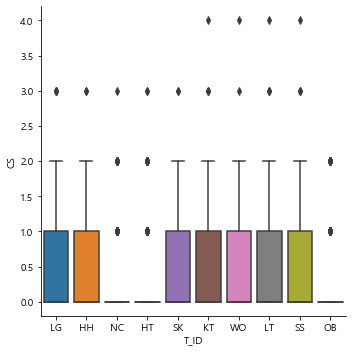

In [24]:
sns.factorplot(data=team,x='T_ID',y='CS',kind='box')

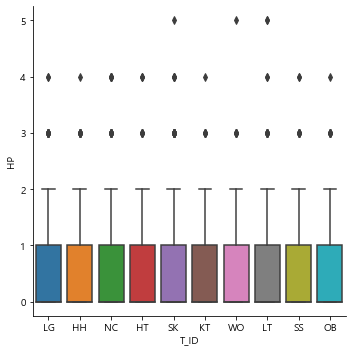

In [25]:
sns.factorplot(data=team,x='T_ID',y='HP',kind='box')

In [26]:

from collections import Counter
def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1 
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index 
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices) 
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n) 
    return multiple_outliers 

#운적인 지표 및 타율에 대해서만 이상치 제거 시행.
#2개 이상의 피쳐에 대해서 이상치가 발생했다면 이상치로 규정(운적인 요소가 많이 작용했을 가능성이 높기 때문에)

In [27]:
team_list=team_2016['T_ID'].unique()
outlier_G_list_hitter=[]
for i in team_list:    
    Outliers_to_drop = detect_outliers(team[team['T_ID']==i], 2, [ 
       'CS',  'HP', 'ERR', 'P_HRA_RT', 'P_AB_CN', 'P_HIT_CN'])
    ID=team[team['T_ID']==i].loc[Outliers_to_drop]['G_ID'].unique()
    outlier_G_list_hitter.extend(ID)
outlier_G_list_hitter.extend(cold_list)    

#고유값 갖게 하기 위해
outlier_G_list_hitter=list(set(outlier_G_list_hitter))

outlier_G_list_hitter

['20200610HTKT0',
 '20190407HHLT0',
 '20190928NCKT0',
 '20190630HTKT0',
 '20190823NCLG0',
 '20170617SKSS0',
 '20170919KTLG0',
 '20180613SKHT0',
 '20170708HTKT0',
 '20170818HHNC0',
 '20180811HTSK0',
 '20180915NCOB0',
 '20170702HTLG0',
 '20170521WOKT0',
 '20170719NCHH0',
 '20170702WOKT0',
 '20190820HTLG0',
 '20190825WOSS0',
 '20190515KTHT0',
 '20160831NCKT0',
 '20170930WONC0',
 '20170702SSSK0',
 '20200625NCKT2',
 '20180904LGKT0',
 '20170917OBSS0',
 '20190831WONC0']

# OUTLIER DETECTION using IQR-팀투수

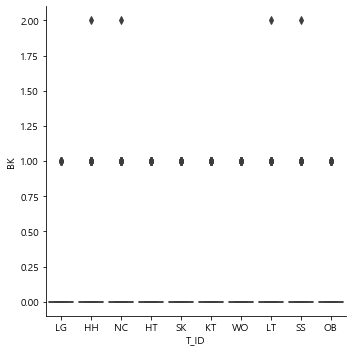

In [28]:
team_2016=data_team_pitcher[0]
team_2017=data_team_pitcher[1]
team_2018=data_team_pitcher[2]
team_2019=data_team_pitcher[3]
team_2020=data_team_pitcher[4]
df_list=[team_2016,team_2017,team_2018,team_2019,team_2020]
team=pd.concat(df_list,axis=0)
sns.factorplot(data=team,x='T_ID',y='BK',kind='box')


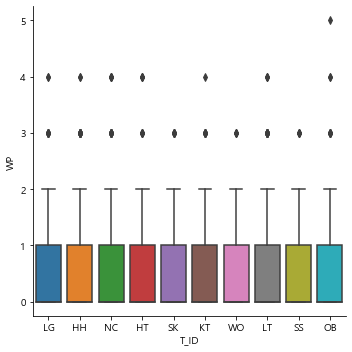

In [29]:
sns.factorplot(data=team,x='T_ID',y='WP',kind='box')


In [30]:

outlier_G_list_pitcher=[]
for i in team_list:    
    Outliers_to_drop = detect_outliers(team[team['T_ID']==i], 3, [ 
       'CS',  'HP', 'ERR', 'BK', 'WP','ER'])
    ID=team[team['T_ID']==i].loc[Outliers_to_drop]['G_ID'].unique()
    outlier_G_list_pitcher.extend(ID)
outlier_G_list_pitcher.extend(cold_list)    

#고유값 갖게 하기 위해
outlier_G_list_pitcher=list(set(outlier_G_list_pitcher))

outlier_G_list_pitcher

['20200610HTKT0',
 '20190407HHLT0',
 '20200512HTHH0',
 '20180523OBHH0',
 '20190608LTKT0',
 '20200705LGSS0',
 '20170702HTLG0',
 '20180610WOKT0',
 '20160408HTKT0',
 '20160505OBLG0',
 '20180422WOHH0',
 '20190521OBKT0',
 '20170616HHKT0',
 '20180529KTSS0',
 '20170702WOKT0',
 '20170502OBSS0',
 '20200602WOHH0',
 '20160619NCKT0',
 '20170702SSSK0',
 '20180426OBSK0']

- 최종적으로는 팀 투수 데이터에서는 outlier_G_list_pitcher에 있는 데이터를, 팀 타자 데이터에서는 outlier_G_list_hitter에 있는 경기 데이터를 지우고 학습 진행